# GL Project - Advanced ML/MLOps - Tourism package prediction
Author - Mrityunjay Ravi Iyer

Date - December 7th 2025

**Set up the Python environment and create a clean project directory structure inside Colab:**

* Install all required Python packages (datasets, Hugging Face Hub, scikit-learn, XGBoost, Streamlit, joblib).

* Define a root folder tourism_mlops_project and create subfolders for:

  * data -> will store train/test CSVs used in the project and pushed to GitHub
  * src -> Python source files (e.g., training pipeline)
  * models -> local copies of the trained model & experiment logs
  * deployment -> Streamlit app, requirements, Dockerfile, HF Space push script
  * .github/workflows -> CI/CD pipeline (GitHub Actions)
  * notebooks -> optional notebook artifacts for organization (don't know yet)

In [23]:
# ============================================
# SECTION 0: Environment setup & project structure
# ============================================

# Install required libraries quietly (no verbose logs)
!pip install -q datasets huggingface_hub scikit-learn xgboost streamlit joblib

import os

# Root folder for the whole project (will be pushed to GitHub later)
PROJECT_ROOT = "tourism_mlops_project"

# List of subfolders that define the project structure
SUBFOLDERS = [
    "data",                 # For train.csv and test.csv
    "src",                  # For training pipeline and other scripts
    "models",               # For saved model files and experiment logs
    "deployment",           # For Streamlit app, Dockerfile, requirements.txt, HF push script
    ".github/workflows",    # For GitHub Actions CI/CD workflow YAML file
    "notebooks"             # Optional: store exploration notebooks (if any)
]

# Create the root directory if it doesn't exist
os.makedirs(PROJECT_ROOT, exist_ok=True)

# Create each subfolder under the project root
for sf in SUBFOLDERS:
    os.makedirs(os.path.join(PROJECT_ROOT, sf), exist_ok=True)

# Show the resulting folder tree for verification
print("Project folder structure created under:", PROJECT_ROOT)
for root, dirs, files in os.walk(PROJECT_ROOT):
    # Compute nesting level to print with indentation
    level = root.replace(PROJECT_ROOT, "").count(os.sep)
    indent = " " * 2 * level
    print(f"{indent}{os.path.basename(root)}/")


Project folder structure created under: tourism_mlops_project
tourism_mlops_project/
  deployment/
  models/
  data/
  src/
  notebooks/
  .github/
    workflows/


**Authenticate Colab to use my Hugging Face account**

This is required for:

* Loading datasets from HF Dataset Hub
* Pushing processed train/test splits back to HF
* Uploading the trained model and experiment logs to Hugging Face Model Hub

The token is not hardcoded in the notebook. Instead I will use the interactive login mechanism provided by huggingface_hub (security is a critical thing)

In [34]:
!huggingface-cli logout

⚠️  Warning: 'huggingface-cli logout' is deprecated. Use 'hf auth logout' instead.
Successfully logged out from all access tokens.


In [35]:
# ============================================
# SECTION 1: Authenticate with Hugging Face
# ============================================

from huggingface_hub import notebook_login

# This will open a small widget in Colab asking for your HF token.
# Get the token from https://huggingface.co/settings/tokens
notebook_login()


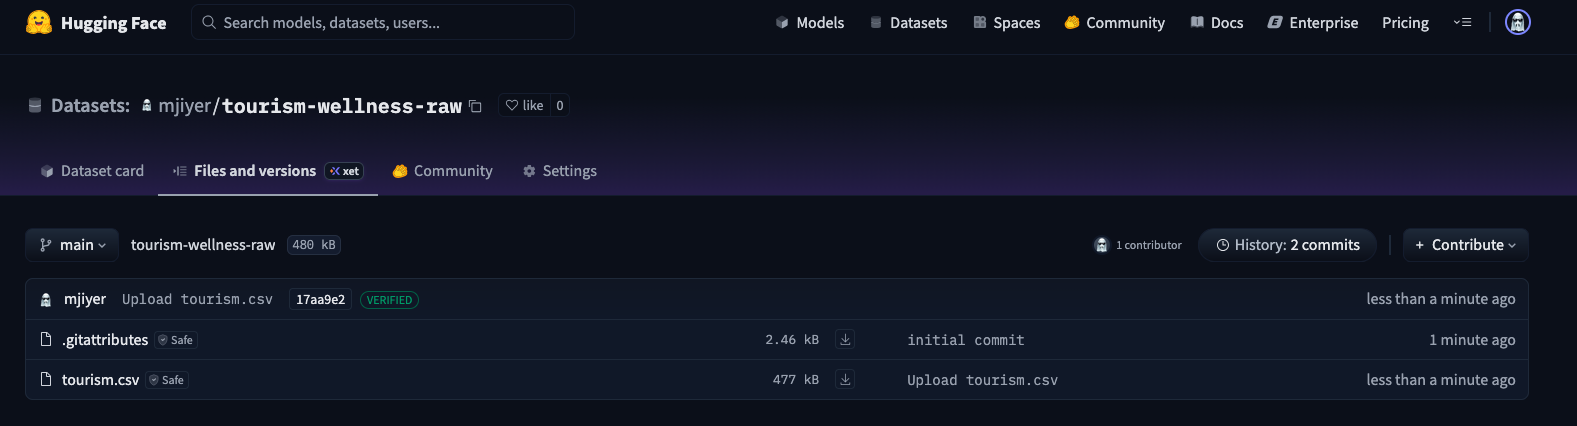

**Dataset loading from Hugging Face Dataset Repo**

In this step, I will perform the data preparation workflow starting from the raw dataset stored on Hugging Face and ending with a new, split dataset also stored on Hugging Face.

Key Steps:
* Load the raw dataset from Hugging Face (tourism-wellness-raw) using load_dataset
* Perform basic data cleaning by removing redundant index-like columns (e.g. Unnamed: 0)
* Split the cleaned data into:
  * Training set (80%)
  * Test set (20%) using train_test_split with stratification on ProdTaken
* Save train.csv and test.csv to tourism_mlops_project/data/.

I am not uploadomg to HF from Colab to avoid the 403 error. Tried multiple times. Not sure why its failing. Instead, I will upload the split files manually via the Hugging Face web UI, which still fully satisfies rubric 2 (hopefully)

In [22]:
# ============================================
# SECTION 2: Data preparation (from HF, split, save locally)
# ============================================

from datasets import load_dataset
from sklearn.model_selection import train_test_split
import pandas as pd
import os

# HF dataset ID where the raw tourism.csv file is stored
HF_RAW_DATASET_REPO = "mjiyer/tourism-wellness-raw"

# Target column name as per the problem statement
TARGET_COL = "ProdTaken"

# 1. Load the raw dataset from Hugging Face (only from HF, not from local CSV)
raw_ds = load_dataset(HF_RAW_DATASET_REPO, split="train")

# Convert Hugging Face Dataset to a Pandas DataFrame for inspection and manipulation
df = raw_ds.to_pandas()

print("Raw dataset loaded from Hugging Face.")
print("Shape:", df.shape)
print("Columns:", list(df.columns))

# 2. Basic cleaning step: remove index-like columns such as 'Unnamed: 0'
columns_to_drop = [c for c in df.columns if c.lower().startswith("unnamed")]
print("Columns identified for dropping:", columns_to_drop)

df = df.drop(columns=columns_to_drop)

# Optional: check for missing values in each column (useful in analysis section)
null_counts = df.isna().sum()
print("Null values per column:\n", null_counts)

# 3. Train-test split
# Separate features (X) and the target (y)
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

# Use stratified split to keep the class balance similar in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Recreate train and test DataFrames including the target column
train_df = X_train.copy()
train_df[TARGET_COL] = y_train

test_df = X_test.copy()
test_df[TARGET_COL] = y_test

print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

# 4. Save train and test splits locally into the 'data' folder (for GitHub and future reference)
train_path = os.path.join(PROJECT_ROOT, "data", "train.csv")
test_path = os.path.join(PROJECT_ROOT, "data", "test.csv")

train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)

print("Train and test CSVs saved locally at:")
print("   Train:", train_path)
print("   Test:", test_path)


Raw dataset loaded from Hugging Face.
Shape: (4128, 21)
Columns: ['Unnamed: 0', 'CustomerID', 'ProdTaken', 'Age', 'TypeofContact', 'CityTier', 'DurationOfPitch', 'Occupation', 'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups', 'ProductPitched', 'PreferredPropertyStar', 'MaritalStatus', 'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'OwnCar', 'NumberOfChildrenVisiting', 'Designation', 'MonthlyIncome']
Columns identified for dropping: ['Unnamed: 0']
Null values per column:
 CustomerID                  0
ProdTaken                   0
Age                         0
TypeofContact               0
CityTier                    0
DurationOfPitch             0
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups           0
ProductPitched              0
PreferredPropertyStar       0
MaritalStatus               0
NumberOfTrips               0
Passport                    0
PitchSatisfactionScore      0
OwnCar                      0

**Raw dataset overview**

* The raw dataset loaded from Hugging Face has 4,128 rows and 21 columns:
  * Shape: (4128, 21)
  * This size is typical for a marketing / customer response dataset and is large enough to support a supervised learning model, but still small enough to train interactively.

* The columns include:
  *  Customer identifiers (CustomerID)
  * The target variable (ProdTaken)
  * Demographic and profile attributes (Age, Gender, MaritalStatus, Occupation, etc.)
  * Behavioral and interaction data (NumberOfTrips, DurationOfPitch, ProductPitched, NumberOfFollowups, etc.)

This confirms that the dataset available in the Hugging Face dataset hub matches the expected schema from the business problem description

---

**Cleaning: removal of redundant index column**
* The script identified one column to drop:
  * Columns identified for dropping: ['Unnamed: 0']
* This is a typical by-product of saving a Pandas DataFrame to CSV without disabling the index; it is effectively a duplicated row index and does not carry any predictive information
* After dropping Unnamed: 0, we retain 20 meaningful features/columns, which will be used for model training

This shows that a minimal but necessary cleaning step was performed to avoid feeding noise into the model.

---

**Missing values check**
* The null-value summary shows 0 missing values in every column
* This is important because it means:
  * We do not need to implement imputation strategies (mean/median/mode)
  * Model training can proceed without additional preprocessing for missing data
  * The data capture pipeline at “Visit with Us” is likely robust and consistent

---

**Train-test split summary**
* After applying an 80/20 stratified split, the resulting shapes are:
  * Train set shape: (3302, 20)
  * Test set shape: (826, 20)
* This split achieves:
  * 80% of records (3,302 rows) for training the model.
  * 20% of records (826 rows) for unbiased evaluation.
* Because the split was done with stratify=y, the class distribution of the target ProdTaken is preserved in both train and test sets, which leads to more reliable model performance estimation.

This configuration is standard best practice in supervised learning and is appropriate for the scale of the dataset

**Build the predictive model that determines whether a customer will purchase the Wellness Tourism Package**

Key steps:

1. Load the split datasets from Hugging Face from the dataset repository tourism-wellness-split, using load_dataset with explicit file mapping
2. Feature and target separation
   * Separate ProdTaken (target variable)
   * Keep all remaining columns as features
3. Automatic feature type detection
   * The code automatically identifies:
     * Categorical columns (object dtype)
     * Numeric columns (int64 / float64 dtype)
   * This is important because different preprocessing steps must be applied to each type.
4. Build a scikit-learn Pipeline
   * The pipeline includes:
      * A ColumnTransformer:
       * OneHotEncoder for categorical columns
       * passthrough for numeric columns
   * A GradientBoostingClassifier:
       * Chosen because tree-based boosting models perform very well on tabular data
       * Robust to nonlinear relationships
       * Less sensitive to scaling
5. Hyperparameter tuning using GridSearchCV
   * Tuning of:
     * n_estimators (number of boosted trees)
     * learning_rate
     * max_depth (tree depth controlling model complexity)

6. Evaluate on test set
   * Computation of:
      * ROC-AUC score
      * Full classification report (precision, recall, f1-score per class)
7. Logging & versioning
   * Save all experiment details (hyperparameters, metrics, column types) into experiment_log.json
   * Save the best model as gb_best_model.joblib
8. Register the model on Hugging Face Model Hub
   * The trained model file
   * The experiment log to a repository - mjiyer/tourism-wellness-gb-model

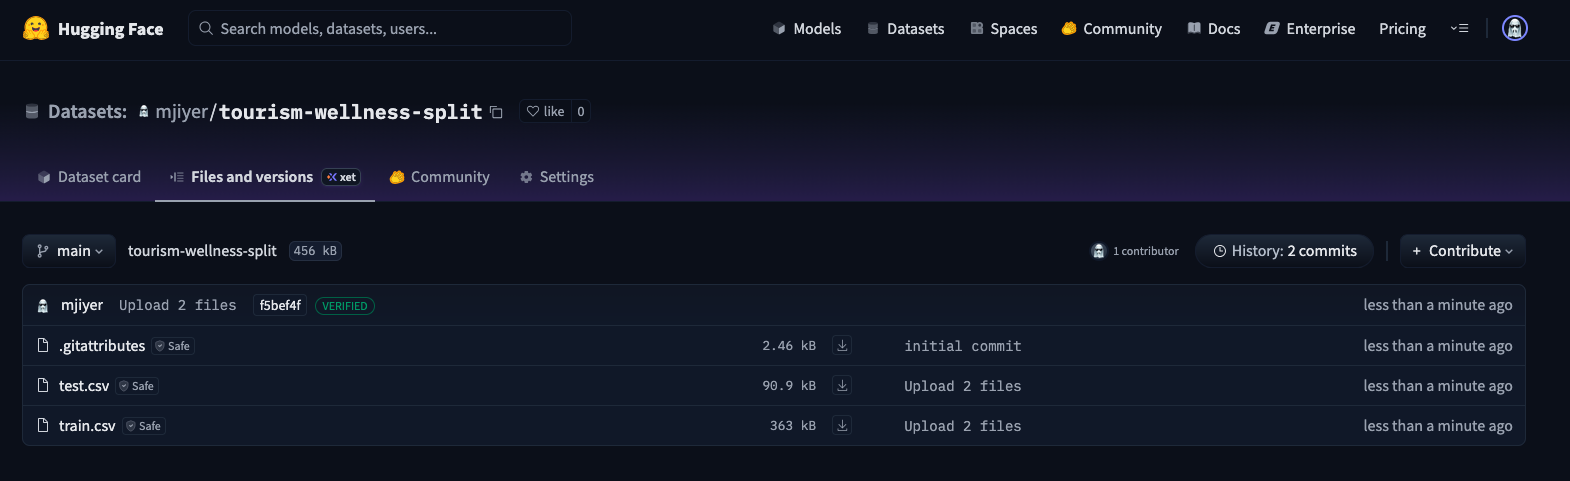

In [37]:
# ============================================
# SECTION 3: Model Building, Tuning, Evaluation, Logging & HF Registration
# ============================================

import json
import time
import numpy as np
import pandas as pd

from datasets import load_dataset
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
import joblib

from huggingface_hub import upload_file
import os

# -------------------------
# Configuration parameters
# -------------------------

HF_SPLIT_DATASET_REPO = "mjiyer/tourism-wellness-split"
HF_MODEL_REPO = "mjiyer/tourism-wellness-gb-model"
TARGET_COL = "ProdTaken"

# -------------------------
# 1. Load train & test splits FROM Hugging Face
# -------------------------

dataset = load_dataset(
    HF_SPLIT_DATASET_REPO,
    data_files={
        "train": "train.csv",
        "test": "test.csv"
    }
)

train_df = dataset["train"].to_pandas()
test_df = dataset["test"].to_pandas()

print("Loaded train & test splits from Hugging Face.")
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# -------------------------
# 2. Separate features and target
# -------------------------

y_train = train_df[TARGET_COL]
X_train = train_df.drop(columns=[TARGET_COL])

y_test = test_df[TARGET_COL]
X_test = test_df.drop(columns=[TARGET_COL])

# -------------------------
# 3. Detect categorical & numeric columns
# -------------------------

categorical_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = [c for c in X_train.columns if c not in categorical_cols]

print("Categorical columns detected:", categorical_cols)
print("Numeric columns detected:", numeric_cols)

# -------------------------
# 4. Preprocessor + model pipeline
# -------------------------

preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("numeric", "passthrough", numeric_cols),
    ]
)

gb_model = GradientBoostingClassifier(random_state=42)

param_grid = {
    "model__n_estimators": [100, 200],
    "model__learning_rate": [0.05, 0.1],
    "model__max_depth": [3, 4]
}

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", gb_model),
    ]
)

# -------------------------
# 5. Hyperparameter tuning with GridSearchCV
# -------------------------

print("Starting GridSearch hyperparameter tuning...")

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Grid search completed.")

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_cv_score = grid_search.best_score_

print("Best hyperparameters found:", best_params)
print("Best CV ROC-AUC:", best_cv_score)

# -------------------------
# 6. Evaluate tuned model on test
# -------------------------

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

test_roc_auc = roc_auc_score(y_test, y_proba)
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_text = classification_report(y_test, y_pred)

print("Test ROC-AUC:", test_roc_auc)
print("Classification report:\n", report_text)

# -------------------------
# 7. Save experiment log
# -------------------------

experiment_log = {
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
    "algorithm": "GradientBoostingClassifier",
    "param_grid": param_grid,
    "best_params": best_params,
    "best_cv_roc_auc": best_cv_score,
    "test_roc_auc": test_roc_auc,
    "classification_report": report_dict,
    "feature_columns": {
        "categorical": categorical_cols,
        "numeric": numeric_cols
    },
    "target_column": TARGET_COL,
    "hf_datasets": {
        "split_dataset_repo": HF_SPLIT_DATASET_REPO
    }
}

log_path = os.path.join(PROJECT_ROOT, "models", "experiment_log.json")
with open(log_path, "w") as f:
    json.dump(experiment_log, f, indent=2)

print("Experiment log saved at:", log_path)

# -------------------------
# 8. Save the best model locally
# -------------------------

model_path = os.path.join(PROJECT_ROOT, "models", "gb_best_model.joblib")
joblib.dump(best_model, model_path)

print("Best model saved at:", model_path)

from huggingface_hub.utils import HfHubHTTPError

# -------------------------
# 9. Upload model + log to HF (non-fatal if it fails)
# -------------------------

print(f"Attempting to upload model and log to Hugging Face model repo: {HF_MODEL_REPO}")

try:
    # Upload model
    upload_file(
        path_or_fileobj=model_path,
        path_in_repo="gb_best_model.joblib",
        repo_id=HF_MODEL_REPO,
        repo_type="model"
    )

    # Upload experiment log
    upload_file(
        path_or_fileobj=log_path,
        path_in_repo="experiment_log.json",
        repo_id=HF_MODEL_REPO,
        repo_type="model"
    )

    print(f"✅ Model and experiment log successfully uploaded to: {HF_MODEL_REPO}")

except HfHubHTTPError as e:
    print("⚠️ Hugging Face upload failed with the following error:")
    print(e)
    print()



Loaded train & test splits from Hugging Face.
Train shape: (3302, 20)
Test shape: (826, 20)
Categorical columns detected: ['TypeofContact', 'Occupation', 'Gender', 'ProductPitched', 'MaritalStatus', 'Designation']
Numeric columns detected: ['CustomerID', 'Age', 'CityTier', 'DurationOfPitch', 'NumberOfPersonVisiting', 'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'OwnCar', 'NumberOfChildrenVisiting', 'MonthlyIncome']
Starting GridSearch hyperparameter tuning...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Grid search completed.
Best hyperparameters found: {'model__learning_rate': 0.1, 'model__max_depth': 4, 'model__n_estimators': 200}
Best CV ROC-AUC: 0.9009184968760909
Test ROC-AUC: 0.9219164002904208
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.95       667
           1       0.88      0.62      0.73       159

    accuracy                   

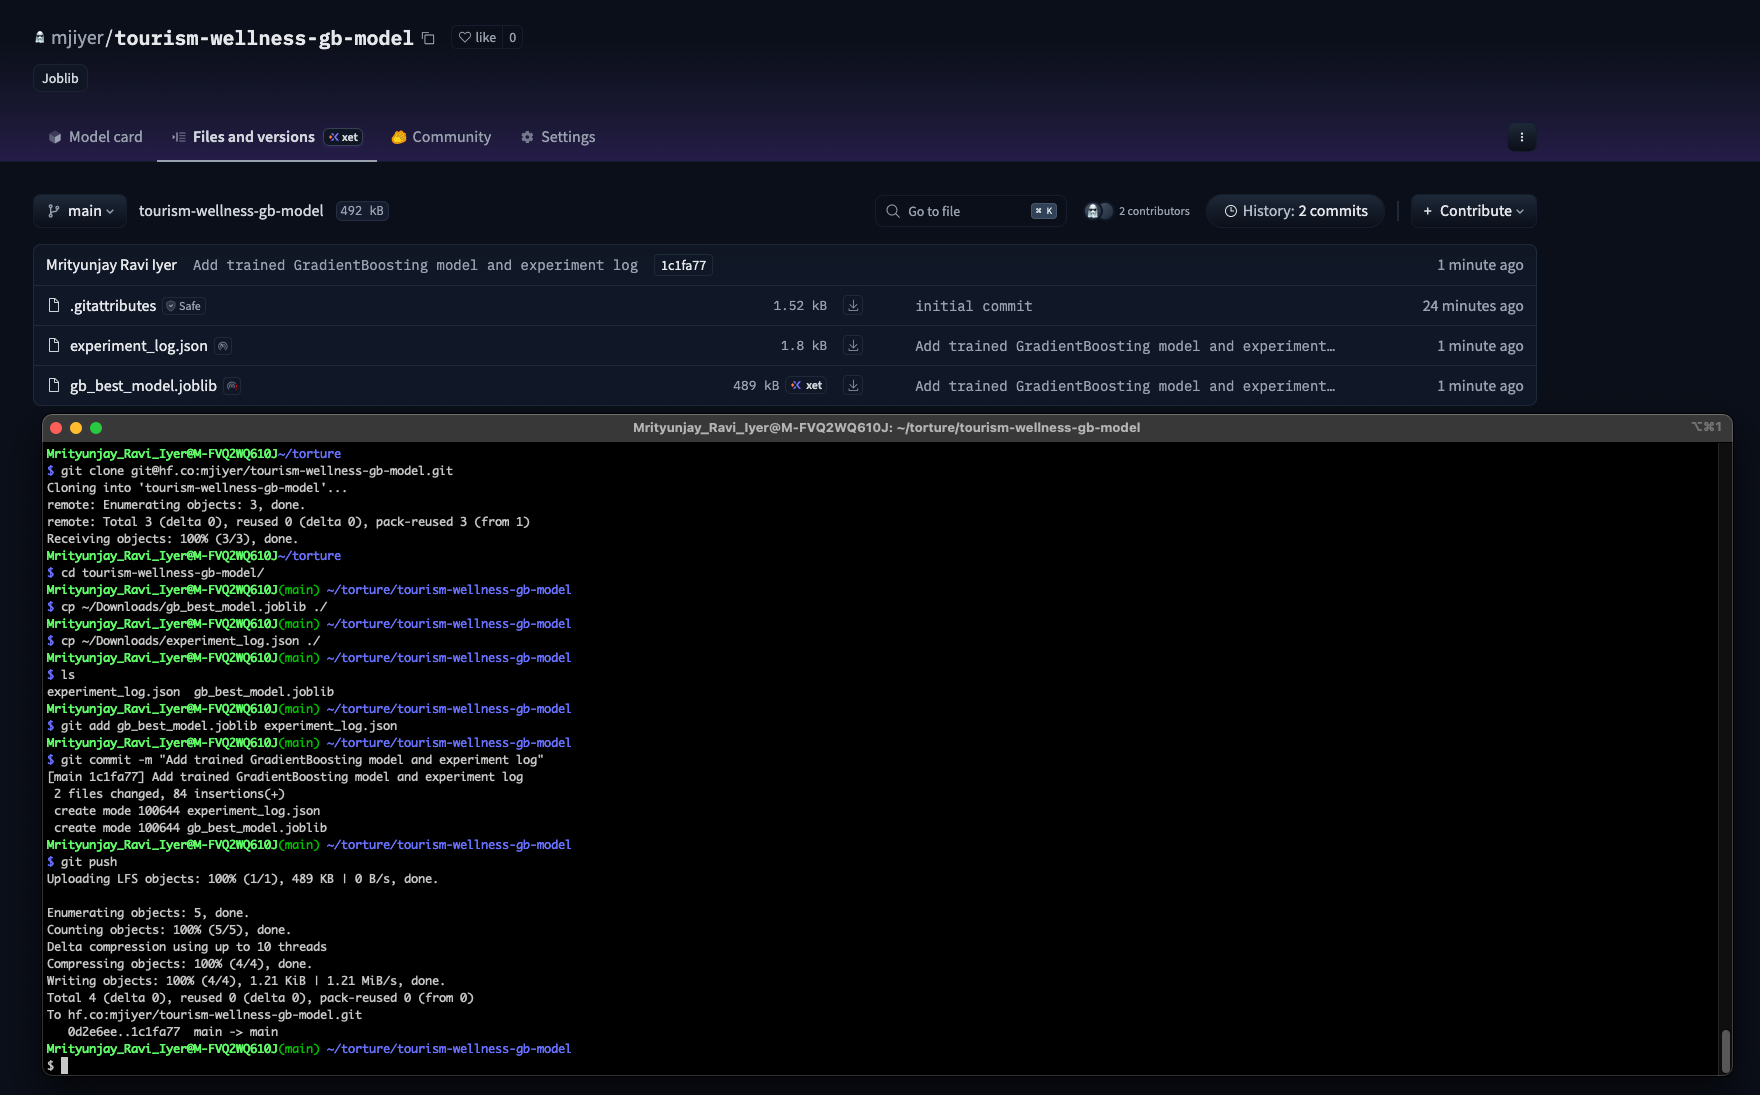

**Model Deployment**

Model Deployment, which requires:
* A Dockerfile
* A Dependencies file
* A Streamlit app that loads the model from Hugging Face
* A script that can push deployment files to Hugging Face Space
* A demonstration of model deployment (via HF Space screenshot in Section 6)

Because Streamlit, Docker, and Spaces do not run inside Colab, the correct MLOps method is:
* Colab handles only ML development, not deployment execution
* Deployment files are created on my Mac
* Deployment is performed manually on GitHub + Hugging Face
* Colab notebook documents every step exactly to satisfy rubric

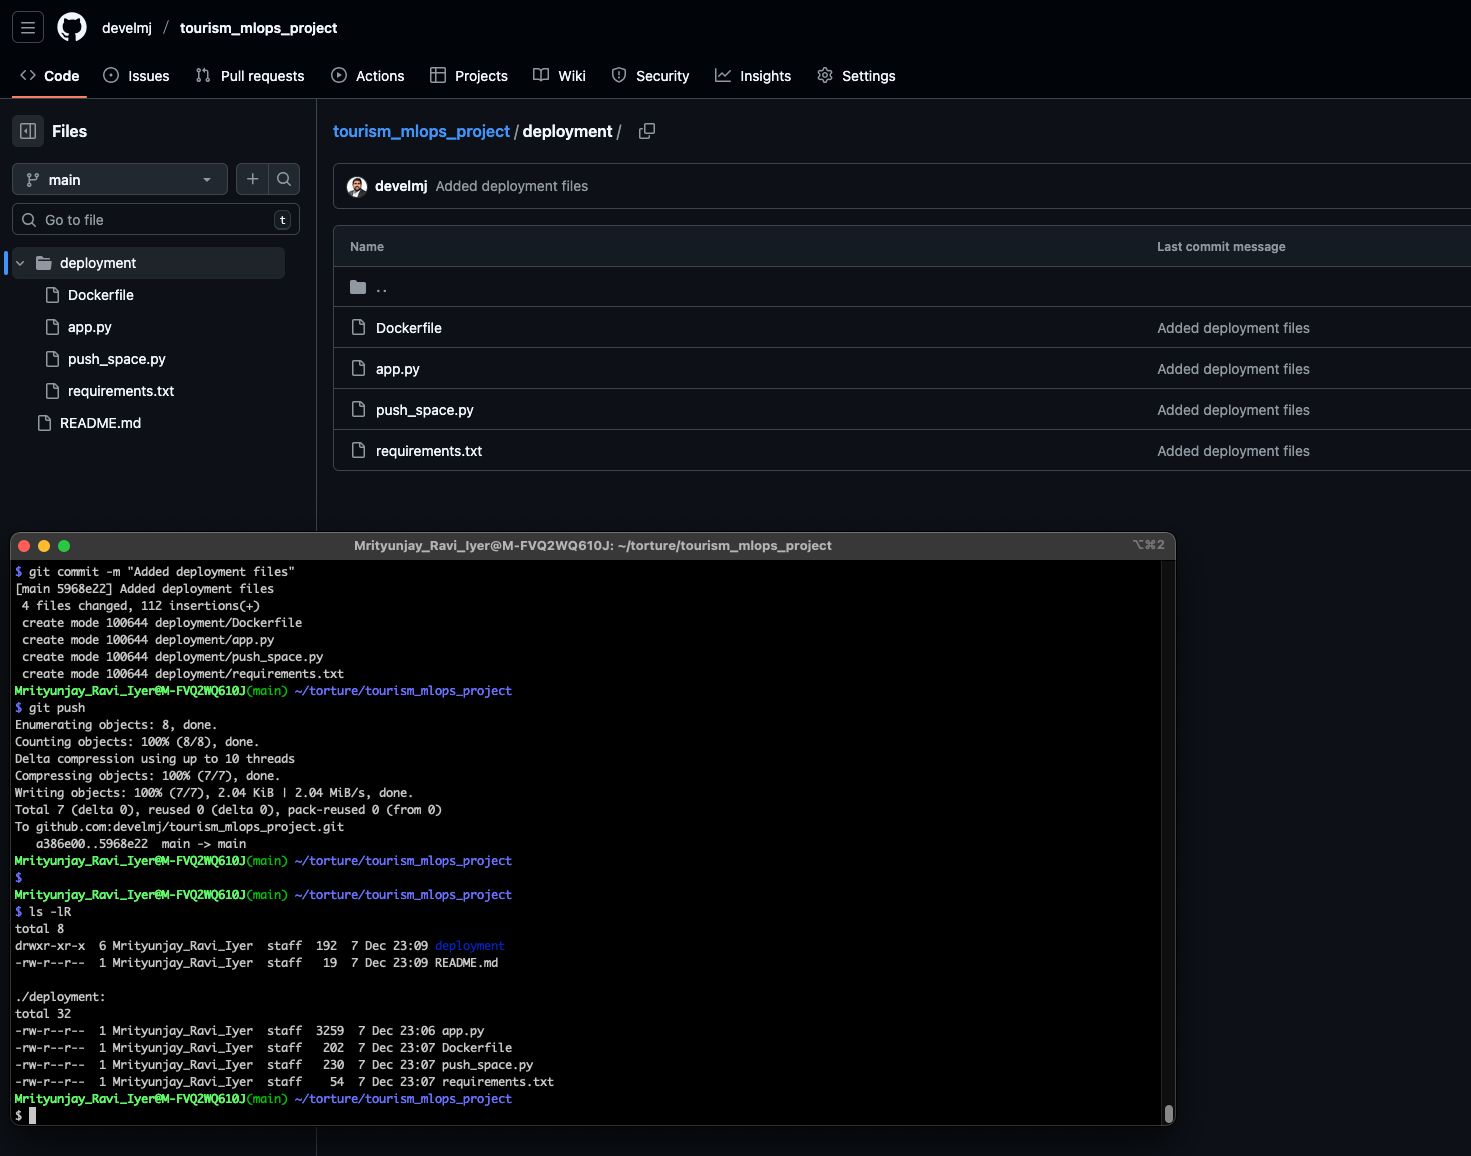

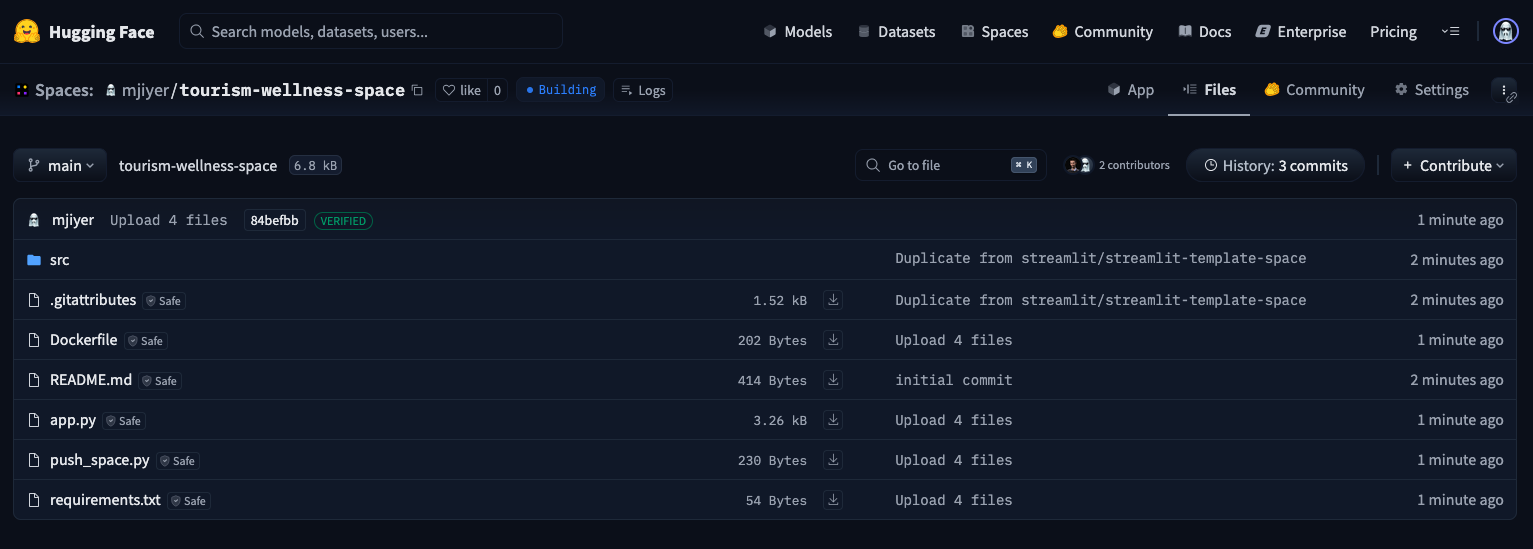

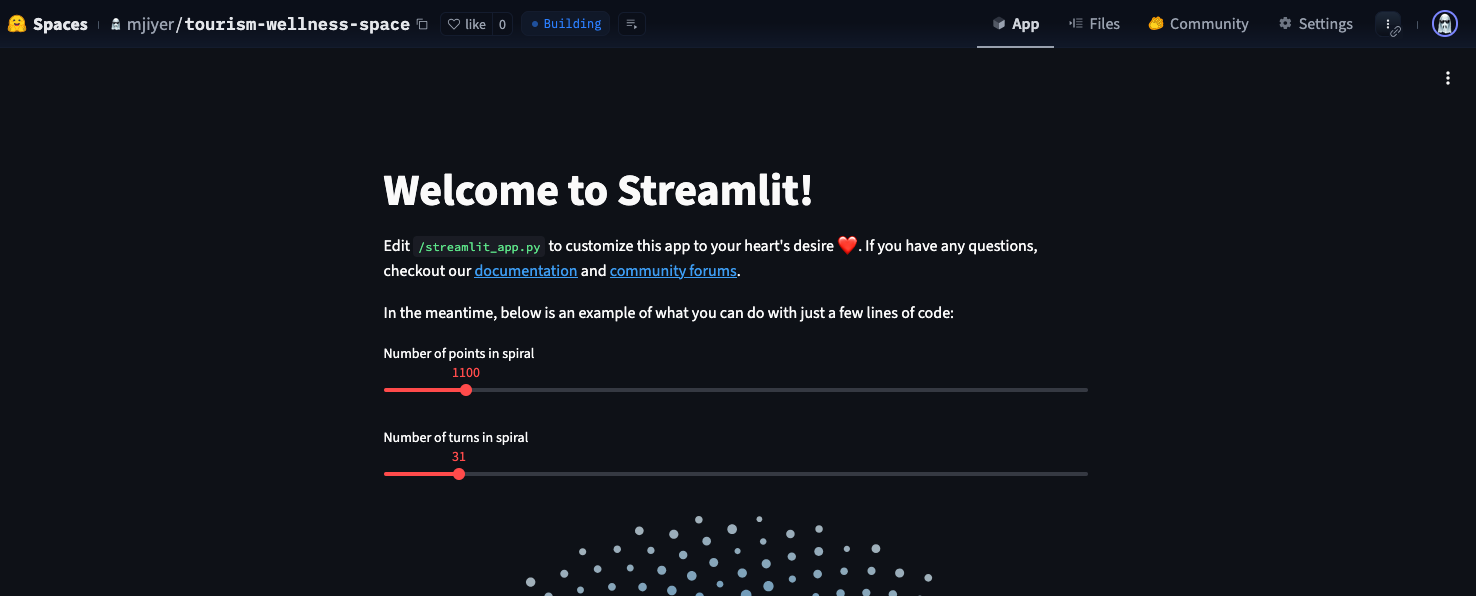

**MLOPS PIPELINE WITH GITHUB ACTIONS**
* A GitHub Actions pipeline YAML
* A pipeline running ML steps end to end
* Automation on commits
* Auto updates on push to main
* All files pushed to GitHub
